## Preparation

In [1]:
import torch
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import cv2

In [2]:
device=torch.device('cuda:1') #先調1再調0

In [3]:
print(torch.cuda.is_available())

True


In [4]:
x=torch.randn(1000, 6724)
x=x.to(device)

C:\Users\ENCHOU\anaconda3\envs\pytorch\lib\site-packages\torch\cuda\__init__.py:120: UserWarning: 
    Found GPU%d %s which is of cuda capability %d.%d.
    PyTorch no longer supports this GPU because it is too old.
    The minimum cuda capability supported by this library is %d.%d.
    
  warnings.warn(old_gpu_warn.format(d, name, major, minor, min_arch // 10, min_arch % 10))


In [5]:
device=torch.device('cuda:0')

## Data

In [6]:
# Step 1. Prepare data-1/2
# DataLoader wraps a Dataset and provides minibatches, shuffling, multithreading, for you
data_in=np.loadtxt('./data/preserved/input_div_U_2_1s.dat')
data_out=np.loadtxt('./data/preserved/input_div_U_2_1s.dat')
x_in=torch.Tensor(data_in)
y_in=torch.Tensor(data_out)
x_in=x_in.to(device)
y_in=y_in.to(device)

In [7]:
x=x_in
y=y_in
print(x.size())
print(y.size())
loader=DataLoader(TensorDataset(x, y), batch_size=200)

torch.Size([1000, 6400])
torch.Size([1000, 6400])


## Model

In [ ]:
# Step 2. Create model 建立model習慣建立class
class TwoLayerNet(torch.nn.Module):
    def __init__(self, D_in, A, B, C, D, E, D_out):
        super(TwoLayerNet, self).__init__()
        self.linear_1=torch.nn.Linear(D_in, A)
        self.linear_2=torch.nn.Linear(A, B)
        self.linear_4=torch.nn.Linear(B, C)
        self.linear_5=torch.nn.Linear(C, D)
        self.linear_6=torch.nn.Linear(D, E)
        self.linear_3=torch.nn.Linear(E, D_out)
    
    # Step 3. Forward pass-1/2    # Step 4. Backward pass-1/2
    def forward(self, x):
        a=self.linear_1(x)
        a_relu=torch.nn.functional.relu(a) #為何activation and hidden layer 的實現方式不同
        b=self.linear_2(a_relu) 
        b_relu=torch.nn.functional.relu(b)
        c=self.linear_4(b_relu) 
        c_relu=torch.nn.functional.relu(c)
        d=self.linear_5(c_relu) 
        d_relu=torch.nn.functional.relu(d)
        e=self.linear_6(d_relu) 
        e_relu=torch.nn.functional.relu(e)
        y_pred=self.linear_3(e_relu) 
        return y_pred
    
model= TwoLayerNet(D_in=6400, A=1000, B=1000, C=1000, D=1000, E=1000, D_out=6400)
model=model.to(device) #這行是什麼意思? A:将模型加载到相应的设备

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class VariationalEncoder(nn.Module):
    def __init__(self, latent_dims):  
        super(VariationalEncoder, self).__init__()
        self.conv1 = nn.Conv2d(1, 4, 3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(4, 8, 3, stride=1, padding=1)
        self.batch2 = nn.BatchNorm2d(8)
        self.conv3 = nn.Conv2d(8, 16, 3, stride=1, padding=1)  
        self.linear1 = nn.Linear(80*80*16, 6400)
        self.linear2 = nn.Linear(6400, latent_dims)
        self.linear3 = nn.Linear(6400, latent_dims)

        self.N = torch.distributions.Normal(0, 1)
        self.N.loc = self.N.loc.cuda() # hack to get sampling on the GPU
        self.N.scale = self.N.scale.cuda()
        self.kl = 0

    def forward(self, x):
        x = x.to(device)
        x = F.relu(self.conv1(x))
        x = F.relu(self.batch2(self.conv2(x)))
        x = F.relu(self.conv3(x))
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.linear1(x))
        mu =  self.linear2(x)
        sigma = torch.exp(self.linear3(x))
        z = mu + sigma*self.N.sample(mu.shape)
        self.kl = (sigma**2 + mu**2 - torch.log(sigma) - 1/2).sum()
        return z      
    
class Decoder(nn.Module):
    
    def __init__(self, latent_dims):
        super().__init__()

        self.decoder_lin = nn.Sequential(
            nn.Linear(latent_dims, 6400),
            nn.ReLU(True),
            nn.Linear(6400, 80 * 80 * 16),
            nn.ReLU(True)
        )

        self.unflatten = nn.Unflatten(dim=1, unflattened_size=(16, 80, 80))

        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(16, 8, 3, stride=1, output_padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 4, 3, stride=1, padding=1, output_padding=1),
            nn.BatchNorm2d(4),
            nn.ReLU(True),
            nn.ConvTranspose2d(4, 1, 3, stride=1, padding=1, output_padding=1)
        )
        
    def forward(self, x):
        x = self.decoder_lin(x)
        x = self.unflatten(x)
        x = self.decoder_conv(x)
        x = torch.sigmoid(x)
        return x

class VariationalAutoencoder(nn.Module):
    def __init__(self, latent_dims):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = VariationalEncoder(latent_dims)
        self.decoder = Decoder(latent_dims)

    def forward(self, x):
        x = x.to(device)
        z = self.encoder(x)
        return self.decoder(z)
    
### Set the random seed for reproducible results
torch.manual_seed(0)
model = VariationalAutoencoder(latent_dims=128).to(device)

In [8]:
# Convolutional neural network (two convolutional layers)
import torch.nn as nn
import torch.nn.functional as F

class ConvNet(torch.nn.Module):
    def __init__(self, channel_1, channel_2, channel_3, channel_4, channel_5, kernel_dim):
        super(ConvNet, self).__init__()
        # 1 input image channel, 6 output channels, 5x5 square convolution
        # kernel
        self.conv1 = nn.Conv2d(1, channel_1, kernel_dim)
        self.conv2 = nn.Conv2d(channel_1, channel_2, kernel_dim)
        self.conv3 = nn.Conv2d(channel_2, channel_3, kernel_dim)
        self.conv4 = nn.Conv2d(channel_3, channel_4, kernel_dim)
        self.conv5 = nn.Conv2d(channel_4, 1, kernel_dim)
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(70*70*1, 6400)  # 78*78 from image dimension
        #self.fc2 = nn.Linear(1000, 1000)
        #self.fc3 = nn.Linear(1000, 6400)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = F.relu(self.conv5(x))
        x = torch.flatten(x, 1) # flatten all dimensions except the batch dimension
        #x = F.relu(self.fc1(x))
        #x = F.relu(self.fc2(x))
        x = self.fc1(x)
        return x

model = ConvNet(channel_1=3, channel_2=3, channel_3=3, channel_4=3, channel_5=3, kernel_dim=3).to(device)

In [9]:
x= torch.nn.Sequential(torch.nn.Unflatten(1, (1,80,80)))(x)

In [10]:
loader=DataLoader(TensorDataset(x, x), batch_size=100)

## Training

In [11]:
tol=1e-4

In [12]:
optimizer=torch.optim.RMSprop(model.parameters(), lr=0.001, alpha=0.99, eps=1e-08, weight_decay=0, momentum=0, centered=False)
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=500, gamma=0.1)

In [12]:
optimizer=torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5000, gamma=0.1)

In [13]:
loss_epoch=[]
loss_values = []
loss=1
epochs=0

print("Epochs    Loss")

while(loss>tol):
    epochs=epochs+1
    scheduler.step()
    
    for x_batch, y_batch in loader:
        # Forward pass
        y_pred=model(x_batch)
        #x_2d= torch.nn.Sequential(torch.nn.Unflatten(1, (1,80,80)))(x_batch)
        # Compute laplacian
        y_pred= torch.nn.Sequential(torch.nn.Unflatten(1, (80,80)))(y_pred)
        
        #with torch.no_grad():
            #y_pred=y_predg*1
            #print(y_pred.requires_grad)
        
        #print(y_pred.requires_grad)
        #y_pred=y_pred.resize_(100, 80, 80)
        #print(y_pred.size())
        z=torch.concat([y_pred[:, :, :1], y_pred], axis=2)[:, :, :80]
        w=torch.concat([y_pred, y_pred[:, :, 79:]], axis=2)[:, :, 1:]
        m=torch.concat([y_pred[:, :1, :], y_pred], axis=1)[:, :80, :]
        n=torch.concat([y_pred, y_pred[:, 79:, :]], axis=1)[:, 1:, :]
        L_y_pred=(z+w+m+n-4*y_pred)*40 # h=1/80 /2h=>*40
        #print(L_y_pred.size())
        
        loss=torch.nn.functional.mse_loss(L_y_pred, x_batch)
        
        # Backward pass
        loss.requires_grad_(True)
        loss.backward()
        
        # Update Weights
        optimizer.step()
        optimizer.zero_grad()
        #print("1 batch")
    
    loss_epoch.append(epochs)
    loss_values.append(loss.item())
    
    if epochs%1==0:
        print("Epochs: ", epochs, "; Loss: ", loss.item())
        
    loss=loss.item()

print(epochs, "    ", loss.item())

#Plot loss function
from matplotlib import pyplot as plt
plt.plot(loss_epoch, loss_values)
plt.xlabel('epochs')
plt.ylabel('loss')

Epochs    Loss


C:\Users\ENCHOU\anaconda3\envs\pytorch\lib\site-packages\torch\optim\lr_scheduler.py:129: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
C:\Users\ENCHOU\AppData\Local\Temp\ipykernel_2696\3864271103.py:33: UserWarning: Using a target size (torch.Size([100, 1, 80, 80])) that is different to the input size (torch.Size([100, 80, 80])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss=torch.nn.functional.mse_loss(L_y_pred, x_batch)


Epochs:  1 ; Loss:  0.27616599202156067
Epochs:  2 ; Loss:  0.16618725657463074
Epochs:  3 ; Loss:  0.09702491015195847
Epochs:  4 ; Loss:  0.07098185271024704
Epochs:  5 ; Loss:  0.05950101464986801
Epochs:  6 ; Loss:  0.05330806225538254
Epochs:  7 ; Loss:  0.0494338683784008
Epochs:  8 ; Loss:  0.046534959226846695
Epochs:  9 ; Loss:  0.04413104057312012
Epochs:  10 ; Loss:  0.042040903121232986
Epochs:  11 ; Loss:  0.04017295315861702
Epochs:  12 ; Loss:  0.03847847133874893
Epochs:  13 ; Loss:  0.03693147376179695
Epochs:  14 ; Loss:  0.035511311143636703
Epochs:  15 ; Loss:  0.03420316427946091
Epochs:  16 ; Loss:  0.03299432620406151
Epochs:  17 ; Loss:  0.03187435120344162
Epochs:  18 ; Loss:  0.030834196135401726
Epochs:  19 ; Loss:  0.029865877702832222
Epochs:  20 ; Loss:  0.028962552547454834
Epochs:  21 ; Loss:  0.028118200600147247
Epochs:  22 ; Loss:  0.02732742950320244
Epochs:  23 ; Loss:  0.026585519313812256
Epochs:  24 ; Loss:  0.025888176634907722
Epochs:  25 ; Los

Epochs:  195 ; Loss:  0.005498790182173252
Epochs:  196 ; Loss:  0.005474988836795092
Epochs:  197 ; Loss:  0.0054504116997122765
Epochs:  198 ; Loss:  0.005427065305411816
Epochs:  199 ; Loss:  0.005406143609434366
Epochs:  200 ; Loss:  0.005379947368055582
Epochs:  201 ; Loss:  0.005359186790883541
Epochs:  202 ; Loss:  0.005334867630153894
Epochs:  203 ; Loss:  0.005312602035701275
Epochs:  204 ; Loss:  0.005290021654218435
Epochs:  205 ; Loss:  0.005268737208098173
Epochs:  206 ; Loss:  0.005246866960078478
Epochs:  207 ; Loss:  0.005224473308771849
Epochs:  208 ; Loss:  0.005204889457672834
Epochs:  209 ; Loss:  0.005181438289582729
Epochs:  210 ; Loss:  0.005163371097296476
Epochs:  211 ; Loss:  0.005142617505043745
Epochs:  212 ; Loss:  0.005120628047734499
Epochs:  213 ; Loss:  0.005099035333842039
Epochs:  214 ; Loss:  0.005082018673419952
Epochs:  215 ; Loss:  0.005062530282884836
Epochs:  216 ; Loss:  0.005038061179220676
Epochs:  217 ; Loss:  0.005022027529776096
Epochs:  2

Epochs:  385 ; Loss:  0.003003861289471388
Epochs:  386 ; Loss:  0.003006239887326956
Epochs:  387 ; Loss:  0.0030147333163768053
Epochs:  388 ; Loss:  0.003025450510904193
Epochs:  389 ; Loss:  0.003005783772096038
Epochs:  390 ; Loss:  0.002962857950478792
Epochs:  391 ; Loss:  0.002951074857264757
Epochs:  392 ; Loss:  0.002947057830169797
Epochs:  393 ; Loss:  0.0029751418624073267
Epochs:  394 ; Loss:  0.0029879393987357616
Epochs:  395 ; Loss:  0.0029603189323097467
Epochs:  396 ; Loss:  0.002977619878947735
Epochs:  397 ; Loss:  0.002941292244940996
Epochs:  398 ; Loss:  0.0029089446179568768
Epochs:  399 ; Loss:  0.002893800614401698
Epochs:  400 ; Loss:  0.0028950078412890434
Epochs:  401 ; Loss:  0.002918716287240386
Epochs:  402 ; Loss:  0.002936634700745344
Epochs:  403 ; Loss:  0.002900030231103301
Epochs:  404 ; Loss:  0.0028833579272031784
Epochs:  405 ; Loss:  0.002880952786654234
Epochs:  406 ; Loss:  0.0028620893135666847
Epochs:  407 ; Loss:  0.002870385767892003
Epo

Epochs:  574 ; Loss:  0.002107859356328845
Epochs:  575 ; Loss:  0.0020892249885946512
Epochs:  576 ; Loss:  0.0021119946613907814
Epochs:  577 ; Loss:  0.002133661648258567
Epochs:  578 ; Loss:  0.0021100298035889864
Epochs:  579 ; Loss:  0.0020759901963174343
Epochs:  580 ; Loss:  0.0020670597441494465
Epochs:  581 ; Loss:  0.0020871178712695837
Epochs:  582 ; Loss:  0.002151709981262684
Epochs:  583 ; Loss:  0.002161681652069092
Epochs:  584 ; Loss:  0.0021371603943407536
Epochs:  585 ; Loss:  0.0020961430855095387
Epochs:  586 ; Loss:  0.0020661447197198868
Epochs:  587 ; Loss:  0.00206693890504539
Epochs:  588 ; Loss:  0.002133185276761651
Epochs:  589 ; Loss:  0.002191901905462146
Epochs:  590 ; Loss:  0.0021100181620568037
Epochs:  591 ; Loss:  0.0020607328042387962
Epochs:  592 ; Loss:  0.0020742809865623713
Epochs:  593 ; Loss:  0.002046857727691531
Epochs:  594 ; Loss:  0.002065698616206646
Epochs:  595 ; Loss:  0.0020982606802135706
Epochs:  596 ; Loss:  0.002059735823422670

Epochs:  762 ; Loss:  0.0017172145890071988
Epochs:  763 ; Loss:  0.0017144352896139026
Epochs:  764 ; Loss:  0.0017078007804229856
Epochs:  765 ; Loss:  0.001729407231323421
Epochs:  766 ; Loss:  0.0017530337208881974
Epochs:  767 ; Loss:  0.0017191184451803565
Epochs:  768 ; Loss:  0.001711932709440589
Epochs:  769 ; Loss:  0.0016846531070768833
Epochs:  770 ; Loss:  0.0016748079797253013
Epochs:  771 ; Loss:  0.0017082493286579847
Epochs:  772 ; Loss:  0.0017150056082755327
Epochs:  773 ; Loss:  0.0017604742897674441
Epochs:  774 ; Loss:  0.0017383664380759
Epochs:  775 ; Loss:  0.0016769953072071075
Epochs:  776 ; Loss:  0.0016554193571209908
Epochs:  777 ; Loss:  0.0016540044452995062
Epochs:  778 ; Loss:  0.0016783657483756542
Epochs:  779 ; Loss:  0.0017641921294853091
Epochs:  780 ; Loss:  0.0017960123950615525
Epochs:  781 ; Loss:  0.0016803106991574168
Epochs:  782 ; Loss:  0.001658282009884715
Epochs:  783 ; Loss:  0.0016448772512376308
Epochs:  784 ; Loss:  0.00166650954633

KeyboardInterrupt: 

## Result

[]

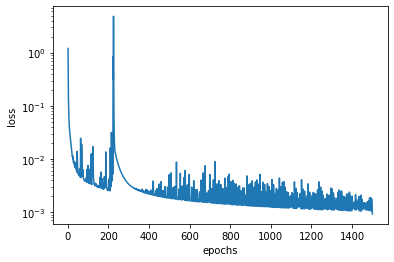

In [16]:
#Plot loss function
from matplotlib import pyplot as plt
plt.plot(loss_epoch, loss_values)
plt.xlabel('epochs')
plt.ylabel('loss')
plt.semilogy()

## Export

In [17]:
device=torch.device('cpu')
model=model.to(device)
PATH= "model_jit_uns_cnn_3.pth"
traced_net=torch.jit.trace(model, (torch.randn(1,6400)).to(device))
traced_net.to(torch.float64)
torch.jit.save(traced_net, PATH)

RuntimeError: Expected 4-dimensional input for 4-dimensional weight [3, 1, 3, 3], but got 2-dimensional input of size [1, 6400] instead

In [20]:
traced_net=torch.jit.trace(model, (torch.randn(1, 1, 80,80)).to(device))
traced_net.to(torch.float64)
torch.jit.save(traced_net, PATH)